In [1]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve
from itertools import combinations
from scipy.stats import pearsonr, spearmanr
import pandas as pd

In [2]:
df = load_data("insurance")
df.head(3)

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


## 미션 1. “이 데이터는 믿을 만할까?”

1-1 결측·이상치·편향을 점검하고, 처리 기준을 제시한다.

통계값확인

+ 1-2 charges가 음수이거나 극단값인지, age/bmi 등의 범위가 현실적인지 확인한다.

'charges'에는 음수가 없지만 극단값(이상값)은 139개 존재한다. age/bmi에 대한 해석이다. 배경지식을 활용해 bmi의 평균이 30이면 매우 높은 수치라고 생각한다. 18세부터 64세까지 데이터가 나타난다.

In [3]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [4]:
df.describe(include = 'O')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


1-3 범주형 변수(sex, smoker, region)가 몇 개의 범주로 구성되어 있고, 특정 범주에 데이터가 지나치게 몰려 있지는 않은지 확인한다.

sex, smoker, region의 범주의 갯수는 각각 2, 2, 4 이다.

In [5]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [6]:
my_dpi = 200
fpath = "C:/Users/itwill/workspace/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(fpath)              
fprop = fm.FontProperties(fname=fpath)     
fname = fprop.get_name()

plt.rcParams['font.family'] = fname    # 그래프에 한글 폰트 적용    
plt.rcParams['font.size'] = 6  # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False # 그래프에 마이너스 깨짐 방지

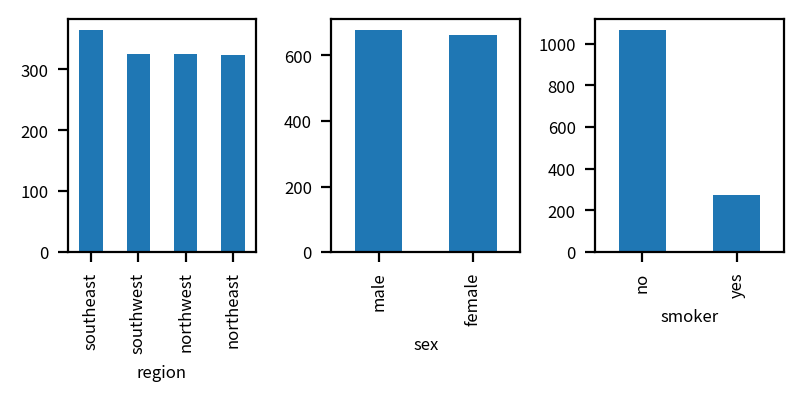

In [7]:
width_px  = 800
height_px = 400
rows = 1
cols = 3
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

cols_1 = ['region', 'sex', 'smoker']

for i, col in enumerate(cols_1):
    df[col].value_counts().plot(kind='bar', ax=ax[i])
    ax[i].set_xlabel(col)


plt.tight_layout()      
plt.show()              
# 여백 제거
# 그래프 화면 출력
plt.close()             
# 그래프 작업 종료

smoker은 비흡연 비율이 많이 몰려 있는 양상(smoker의 비흡연자 비율이 높은 것은 모델링 시 클래스 불균형 문제로 이어질 수 있음), 나머지 두 변수는 골고루 퍼져있다.

결측치 판단

In [8]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

결측치 없음

왜도, 이상치 판단

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
cols = df.columns[df.dtypes == 'object']
df1 = df.drop(columns = cols, axis = 1)
df1.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


'children' 약한 왜도, 이상치 판단
'charges' 중간 왜도, 변환고려, 이상치 판단

In [11]:
df1.skew()

age         0.055673
bmi         0.284047
children    0.938380
charges     1.515880
dtype: float64

왜도가 1이 넘는 'charges'은 iqr을 활용해 이상치 판다나
거의 대칭을 이루는 'age', 'bmi'와 약한 왜도를 보이는 'children'은 zscore로 판단

In [12]:
q1 = df['charges'].quantile(0.25)
q3 = df['charges'].quantile(0.75)
iqr = q3 - q1
l_c = q1 - 1.5 * iqr
u_c = q3 + 1.5 * iqr

In [13]:
((df['charges'] > u_c) | (df['charges'] < l_c)).sum()

np.int64(139)

In [14]:
# 이상치와 왜도 검정
data = df[['children', 'age', 'bmi']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))


    results[col] = {'original_skew': skew_original, 'log_skew': skew_log, 'outliers(|z/>3)': outlier_count, 'log_recommended': need_log,}


results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 점검 결과
outlier_flag = len(results_df[results_df['outliers(|z/>3)'] > 0]) > 0
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")

,original_skew,log_skew,outliers(|z/>3),log_recommended
children,0.93838,0.432129,18,False
age,0.055673,-0.988574,0,False
bmi,0.284047,-0.963062,4,False


이상치가 발견되어 스피어만 상관계수 사용


'charges', 'children', 'age', 'bmi' 각각 이상치가 139개, 18개, 0개, 4개 발견되었다.
'children', 'age', 'bmi'은 왜도가 1을 넘지 않아 로그변환을 진행하지 않아도 되며 age를 제외한 나머지 두 변수는 상관계수를 구할때 spearman방법을 사용해야한다. age는 pearson 상관을 진행한다.
'charges'는 로그 변환을 진행 하여 이상치의 영향을 줄인다.

1-4 전처리 전·후가 어떻게 달라졌는지 한눈에 비교하는 표나 요약을 만든다.

In [15]:
dfl = df.copy()
dfl['charges'] = np.log(dfl['charges'])
dfl.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,9.734176
1,18,male,33.77,1,no,southeast,7.453302
2,28,male,33.00,3,no,southeast,8.400538


<Axes: >

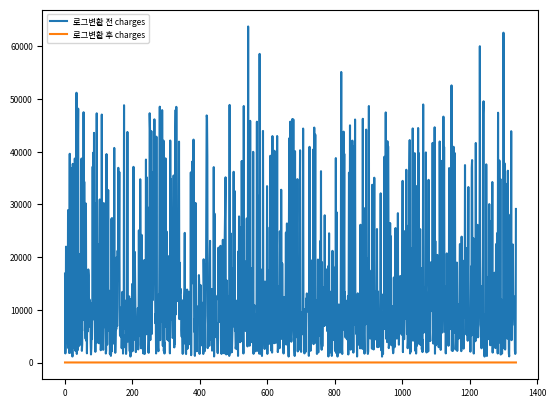

In [16]:
a = df['charges']
b = dfl['charges']
c = pd.DataFrame({
    '로그변환 전 charges' : a,
    '로그변환 후 charges' : b
})
c.plot()

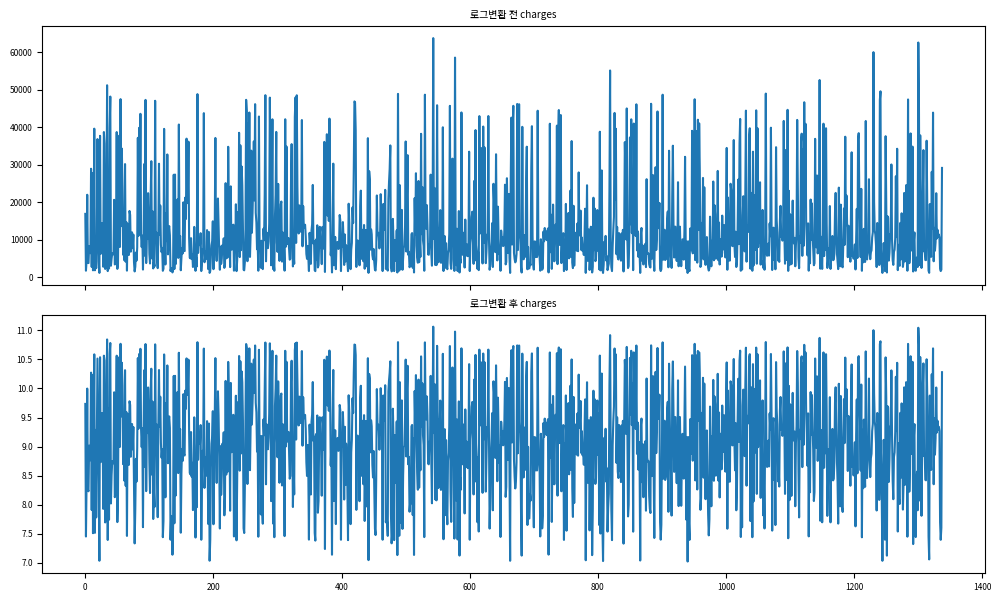

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(a)
ax[0].set_title('로그변환 전 charges')

ax[1].plot(b)
ax[1].set_title('로그변환 후 charges')

plt.tight_layout()
plt.show()

1-4 단위 해석 주의 : charges는 USD입니다. 현실적인 의료비 수준인지 평가하세요.

평균이 13270.422265달러를 보고 매우 높은 수치라고 생각하였다. 하지만 비교 대상이 필요할 것 같다. 추후 비슷한 경제규모의 국가,도시이면서 의료비를 적게 내는 곳을 판단하여 비교하면 좋을 것 같다.

## 미션 2. “의료비와 핵심 변수의 첫인상”

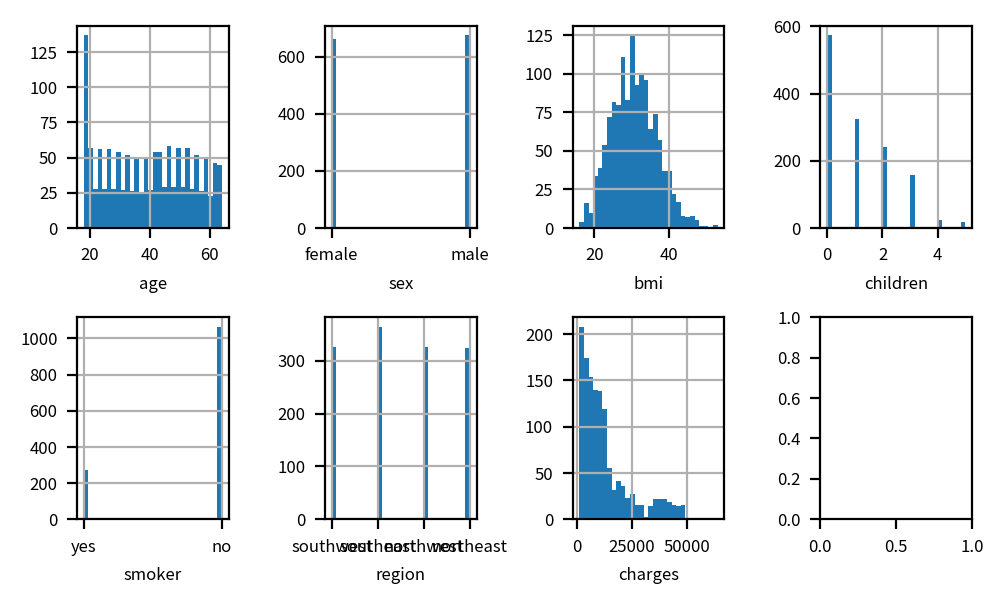

In [18]:
width_px  = 1000
height_px = 600
rows = 2
cols = 4
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

cols_1 = df.columns
ax = ax.flatten() 
for i, col in enumerate(cols_1):
    df[col].hist(bins=30, ax=ax[i])
    ax[i].set_xlabel(col)


plt.tight_layout()      
plt.show()              
# 여백 제거
# 그래프 화면 출력
plt.close()             
# 그래프 작업 종료

알 수 있는 객관적 사실 : 나이는 특정 구간(20이하)가 급격히 많으며 나머지는 낮은 산포도를 보인다. 성별은 남, 여가 골고루 분포한다. bmi는 정규분포와 비슷한 모양을 보인다. 왜도가 낮을 것 이다. 자녀수는 우하향 모양을 보이며 0이 가장 많다. 흡연 여부는 비흡연자가 흡연자에 비해 월등히 많다. 지역은 서로 균등한 모양을 보인다. 의료보험 청구 비용은 낮은 비용이 대다수를 차지하고 일정 구간 이후는 비슷한 모양을 보인다.

## 미션 3. “로그/비선형 변환을 고민해 보자”

로그변환은 미션1에서 전처리과정에서 진행완료!

3-2 변환이 해석과 모델 적합에 주는 장단점, 해석이 어떻게 달라지는지 예상한다.

로그변환으로 극단값의 영향을 완화하고 분포를 고르게 해준다.
하지만 단위에 로그를 취함으로서 직관적으로 변화를 볼 수 없다.
또 log에는 0이 존재하지 않기때문에 log1p를 사용하는데 log(n+1) +1을 해주기때문에 해석이 어려워질 수 있다.

3-3 선택 기준을 명시하세요: 왜 log(charges)인지, 왜 특정 변수에 변환을 적용하는지 데이터 분포 근거로 설명합니다.

미션1에서 이상치와 왜도를 분석했다.
'charges', 'children', 'age', 'bmi' 각각 이상치가 139개, 18개, 0개, 4개 발견되었다.
'children', 'age', 'bmi'은 왜도가 1을 넘지 않아 로그변환을 진행하지 않아도 되며 age를 제외한 나머지 두 변수는 상관계수를 구할때 spearman방법을 사용해야한다. age는 pearson 상관을 진행한다.
'charges'는 로그 변환을 진행 하여 이상치의 영향을 줄인다.

## 미션 4. “성별과 거주 지역은 의료비를 결정할까?”

4-1 성별(sex)과 지역(region)별 의료비 분포를 시각화(박스플롯, 바이올린 플롯)한다.

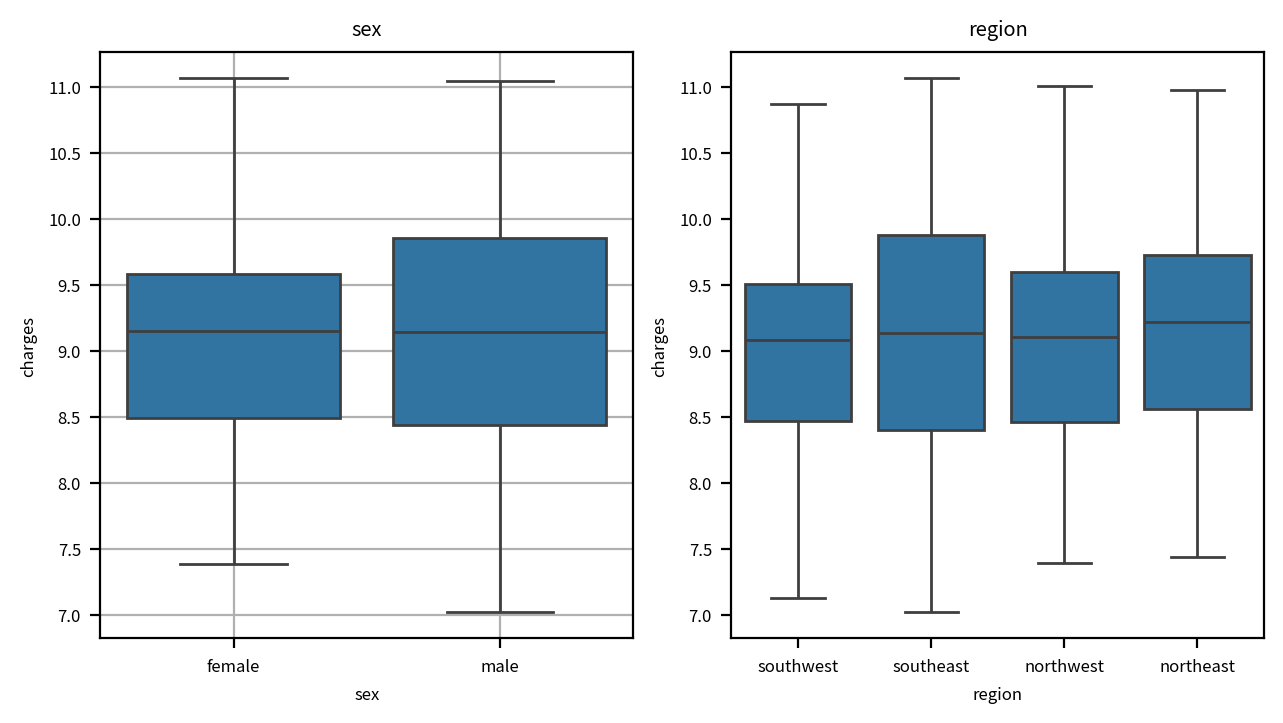

In [19]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px  = 1280 # 그래프 가로 크기
height_px = 720  # 그래프 세로 크기
rows = 1  # 도화지의 행 수
cols = 2  # 도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

axes = ax.flatten()

cols4 = ['sex', 'region']
for i, col in enumerate(cols4):
    sb.boxplot(dfl, x=dfl[col], y = 'charges', ax=axes[i])
    axes[i].set_title(col)
    axes[i].grid(True)

plt.grid() # 배경 격자 표시/숨김 (테마에 따라 다름)

# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력a
plt.close() # 그래프 작업 종료

4-2 중앙값·분포 겹침을 근거로 “어느 집단이 비싼가?”, “차이가 얼마나 뚜렷한가?”를 문장으로 적으세요.

성별에 대한 분석이다. 로그변환으로 이상값이 보이지 않으며, 남여의 중앙값과 사분위수 q1의 차이는 크게 나타나지 않으나 사분위수 q3값이 남성이 더 높다. 즉 상위 의료비 청구구간은 남성이 여성보다 높은 값을 보인다. 하지만 두 분포가 크게 다르지 않기 때문에 성별에 따른 차이라고 단정할 수 없다.
지역에 대한 분석이다. 로그변환으로 이상값이 보이지 않으며, 중앙값과 q1값의 차이는 크지 않으나 q3의 값이 southeast > northeast > northwest > southwet 순으로 차이를 보인다. 즉 상위 의료비 청구 구간에서는 지역 간 차이가 존재한다. 하지만 두 분포가 크게 다르지 않기 때문에 지역에 따른 차이라고 단정할 수 없다.
성별은 독립 t-test, 지역은 분산분석을 수행하여 통계적으로 유의미한 차이가 있는지 확인해봐야겟다

4-3 “왜 이런 차이가 생겼을까?”를 건강보험 체계·지역 의료 인프라·생활 비용 차이 등으로 추정해 보세요.

토론 필요

## 미션 5. “흡연은 정말로 의료비를 크게 높일까?”

5-1 smoker(흡연 여부)에 따라 charges가 다른지 시각화하고, 두 집단 평균 차이를 가설검정(예: t-test)으로 확인한다.

In [20]:
dfsy = dfl[dfl['smoker'] == 'yes']
dfsn = dfl[dfl['smoker'] == 'no']
print(dfsy.shape, dfsn.shape)

(274, 7) (1064, 7)


두 집단의 평균 차이비교 임으로 독립T검정을 실시한다.
정규성과 등분산성 검정을 실시한다.

1. 정규성 검정, 결과 : 귀무가설기각 즉 정규성을 따르지 않는다.

In [21]:
print(stats.shapiro(dfsy['charges']), stats.shapiro(dfsn['charges']))

ShapiroResult(statistic=np.float64(0.9288107694783998), pvalue=np.float64(3.473881982949804e-10)) ShapiroResult(statistic=np.float64(0.9761633788457942), pvalue=np.float64(3.2319758958336162e-12))


2. 등분산 검정 실시, 결과 : 귀무가설 기각 즉 등분산 아님

In [22]:
stats.levene(dfsy['charges'], dfsn['charges'])

LeveneResult(statistic=np.float64(89.49618227738145), pvalue=np.float64(1.3326187283081887e-20))

비모수 독립t검정 만휘트니 검정 실시, 결과 : 귀무가설 기각 즉 흡연여부에 따른 'charges'의 차이가 존재한다. (5-3답)

In [23]:
stats.mannwhitneyu(dfsy['charges'], dfsn['charges'])

MannwhitneyuResult(statistic=np.float64(284133.0), pvalue=np.float64(5.270233444503571e-130))

5-2  효과 크기(차이의 크기)를 함께 제시하고, “실제로 의미 있는 차이인가?”를 말로 해석하세요.

만휘트니 검정 결과 검정통계량 284133, 유의확률 5.270233444503571e-130 으로 유의수준 0.05보다 매우 작은 값임으로 통계적으로 명확한 차이가 보인다.

## 미션 6. “나이대별로 의료비 차이가 뚜렷할까?”

6-1 age를 여러 구간으로 나누어(예: 18~30, 31~50, 51+) 각 연령대별 charges 분포를 시각화한다.

In [24]:
df['age']

0       19
1       18
2       28
3       33
4       32
        ..
1333    50
1334    18
1335    18
1336    21
1337    61
Name: age, Length: 1338, dtype: int64

In [25]:
bins = [17, 30, 50, dfl['age'].max()]
labels = ['18~30', '31~50', '51+']

dfl['age_group'] = pd.cut(dfl['age'], bins=bins, labels=labels)
dfl['age_group'].value_counts()

age_group
31~50    538
18~30    444
51+      356
Name: count, dtype: int64

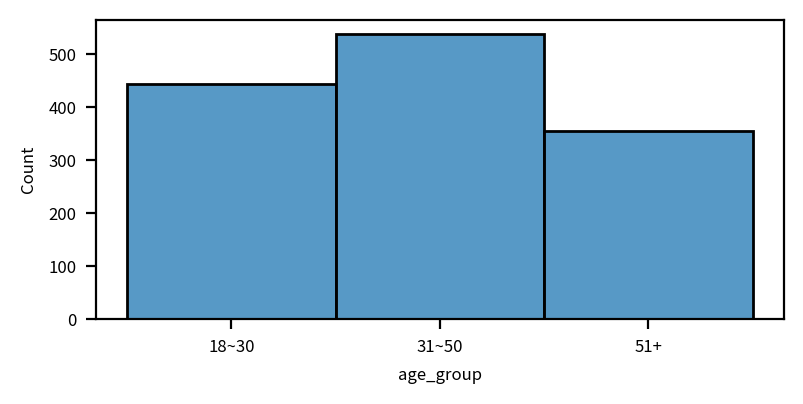

In [26]:
width_px  = 800
height_px = 400
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.histplot(data=dfl['age_group'], bins=5)

plt.tight_layout()
plt.show()
plt.close()

각 그룹의 빈도를 보여줄 뿐 charges의 분포를 보여주지 않는다. 따라서 age_group별 charges의 분포를 비교하는 시각화를 작성하면 좋을것

6-2 분산분석(ANOVA)으로 전체 차이를 확인하고, 사후검정으로 어느 연령대 사이에서 차이가 나는지 정리한다.

정규성, 등분산성, 독립성(있다 라는 가정) 검정 실시

정규성 검정 실시, 결과 : 3구간 모두 귀무가설 기각 즉 정규성 만족하지 않음

In [27]:
df6_1 = dfl[dfl['age_group'] == '18~30']
df6_2 = dfl[dfl['age_group'] == '31~50']
df6_3 = dfl[dfl['age_group'] == '51+']

In [28]:
print(stats.shapiro(df6_1['charges']), stats.shapiro(df6_2['charges']), stats.shapiro(df6_3['charges']))

ShapiroResult(statistic=np.float64(0.8720731010911933), pvalue=np.float64(1.1744696263988118e-18)) ShapiroResult(statistic=np.float64(0.8808859857624945), pvalue=np.float64(6.517883369596651e-20)) ShapiroResult(statistic=np.float64(0.799470610886889), pvalue=np.float64(1.1666973624974481e-20))


등분산성 검정실시, 결과 : 귀무가설 채택 즉 등분산임

In [29]:
stats.levene(df6_1['charges'], df6_2['charges'], df6_3['charges'])

LeveneResult(statistic=np.float64(78.71990387813368), pvalue=np.float64(4.815202388261656e-33))

정규성 X 임으로 쿠르스칼왈리스 검정 진행, 결과 : 귀무가설 기각 즉 나이대별 의료비 차이가 있다.

In [30]:
stats.kruskal(df6_1['charges'], df6_2['charges'], df6_3['charges'])

KruskalResult(statistic=np.float64(326.52421404125573), pvalue=np.float64(1.247865612614743e-71))

귀무가설 기각했으므로 사후검정 실시, 비모수임으로 게임호윌, 투키 사용 불가 따라서 Dunn검정 실시

In [31]:
import scikit_posthocs as sp

sp.posthoc_dunn(df,
    val_col='charges',
    group_col='age_group',
    p_adjust='bonferroni'
)

ValueError: Specify correct column names using `group_col` and `val_col` args

사후검정 결과 18~30 구간과 51+ 구간의 차이가 가장 크고 그다음이 18~30, 30~50 이다.

## 미션 7. “변수들은 서로 섞여 있을까?”

7-1 주요 연속형 변수 간 상관행렬(age, bmi, children, charges)을 계산한다.

성형성 확인

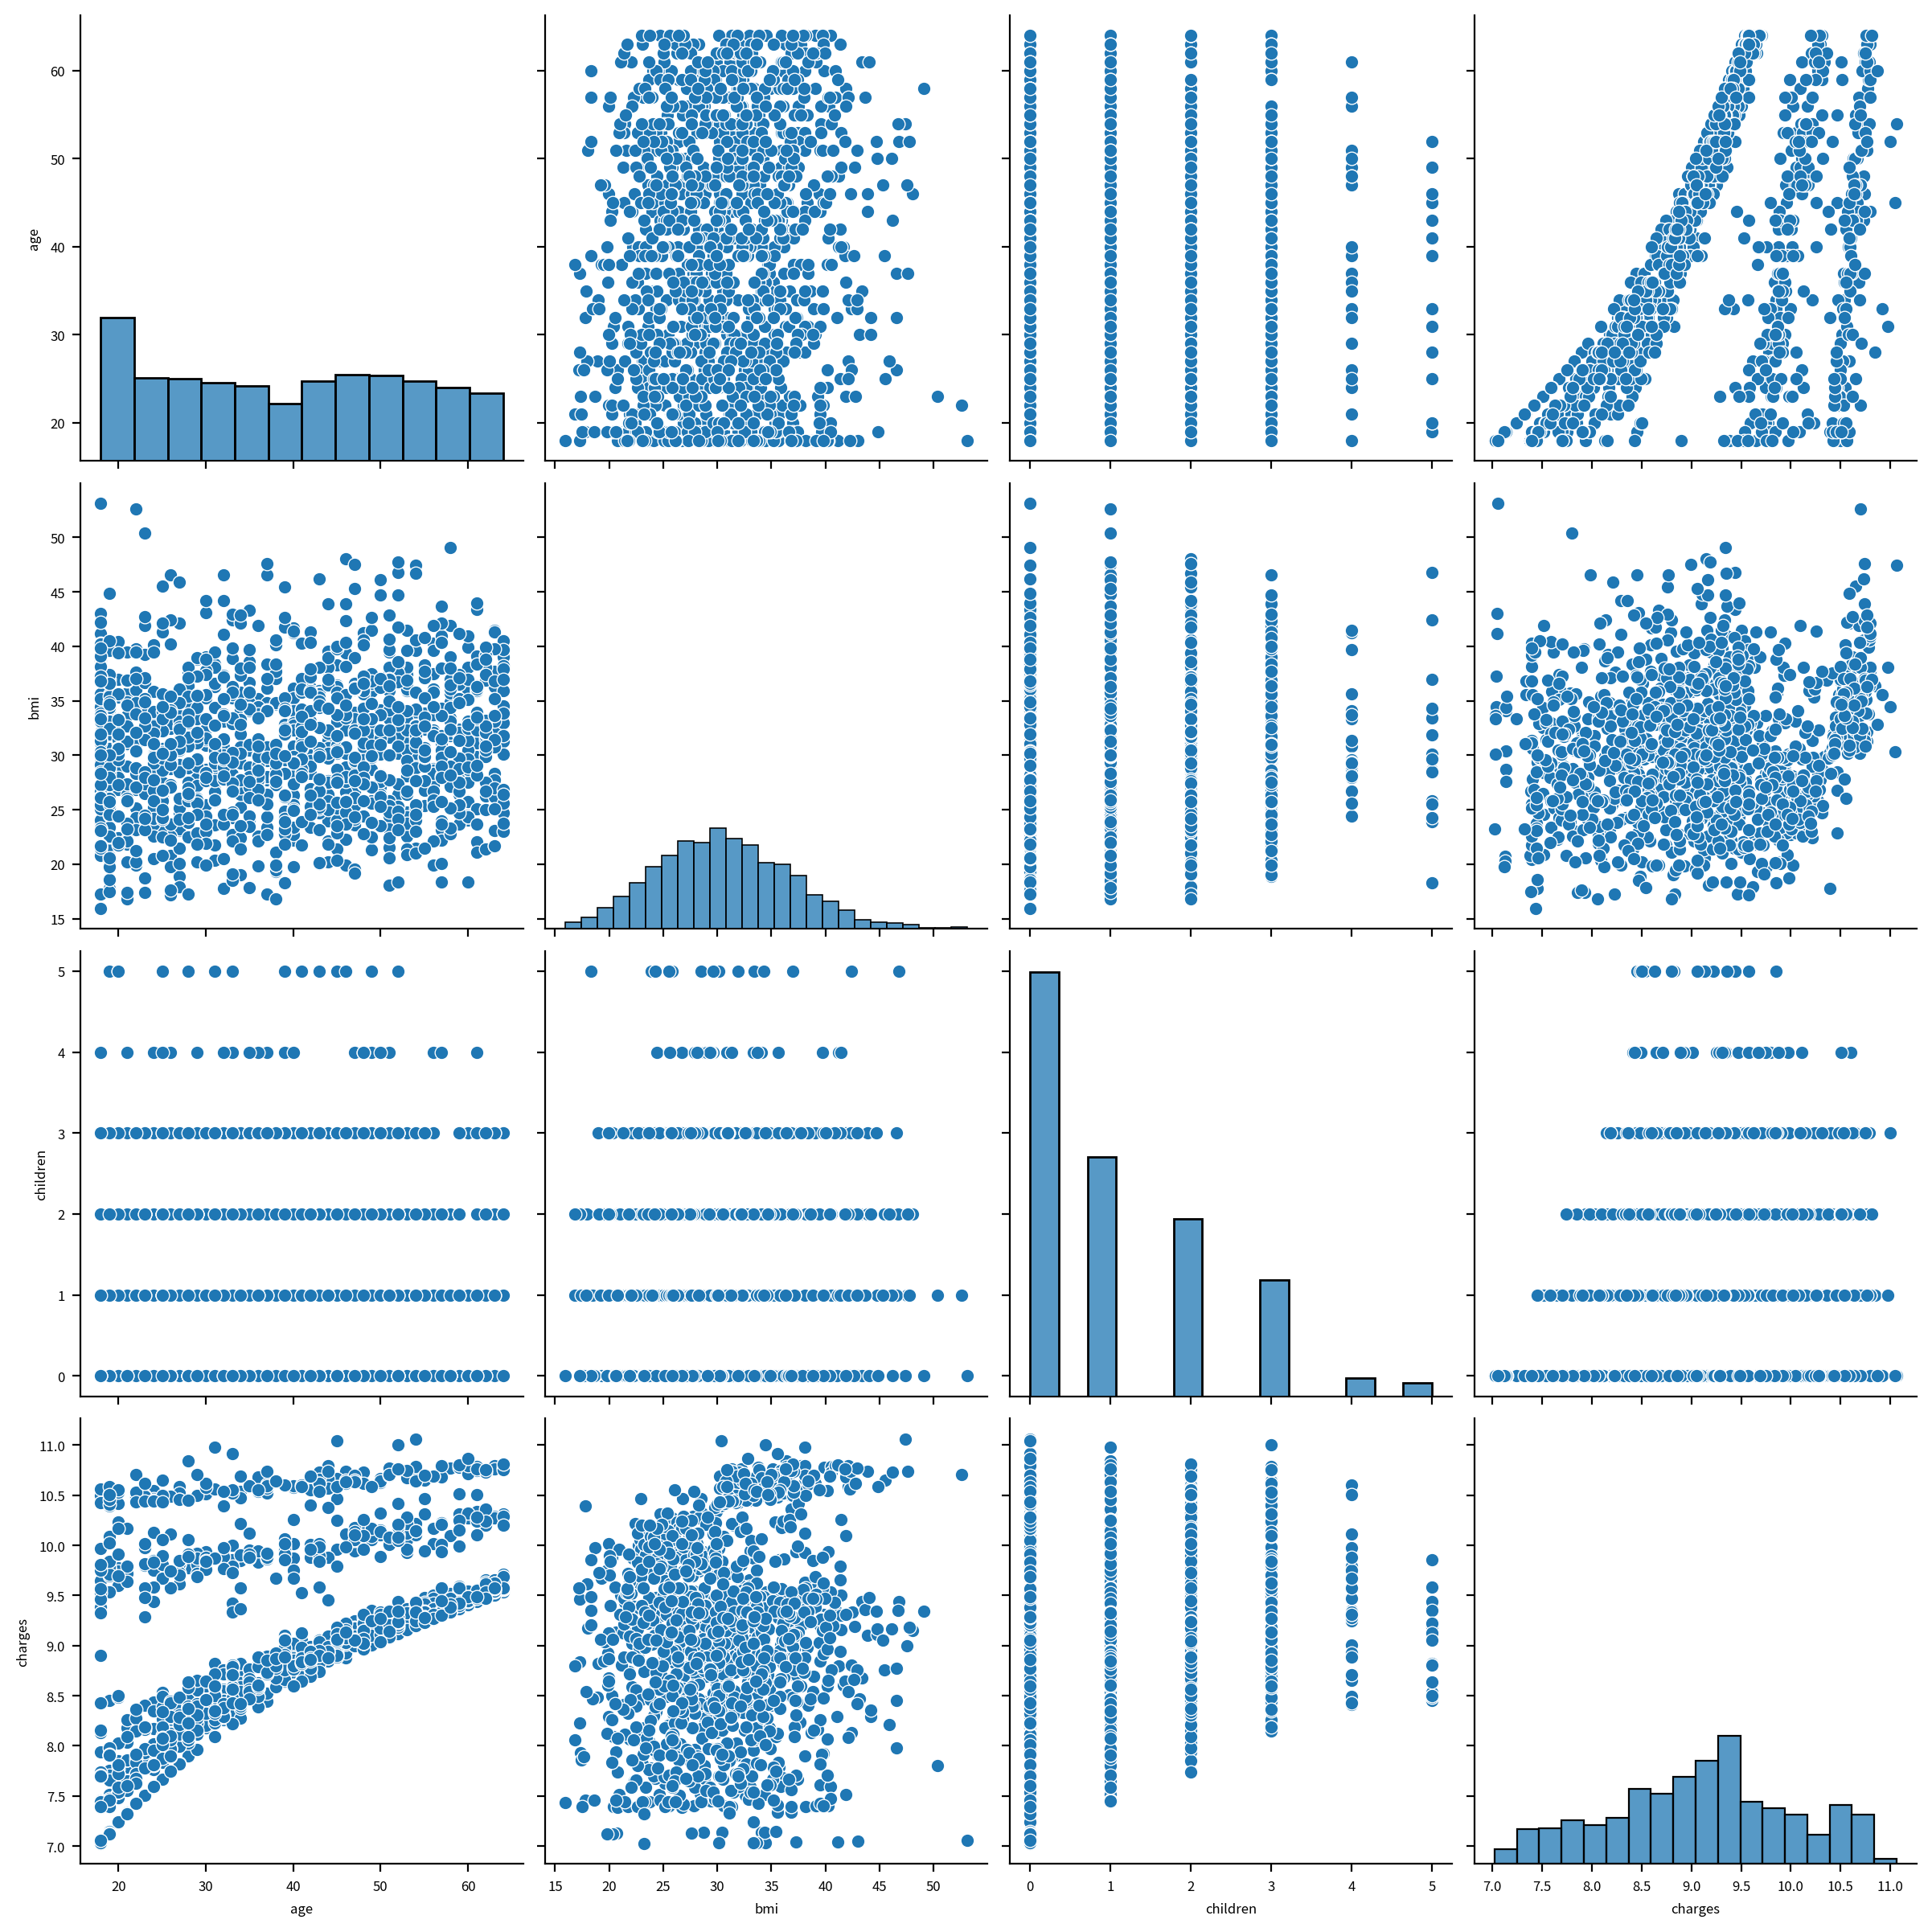

In [32]:
width_px = 2400
height_px = 2400
figsize = (width_px / my_dpi, height_px / my_dpi)

df7 = dfl.filter(items = ['age', 'bmi', 'children', 'charges'])

g = sb.pairplot(df7, diag_kind='hist')
g.fig.set_size_inches(figsize)
g.fig.set_dpi(my_dpi)
plt.tight_layout()
plt.show()
plt.close()

 bmi – charges은 선형이라고 보기 어렵다. children – charges도 선형이라고 하기 어려울 것 같다. 복잡하고 보기 어려움.

In [33]:
df7e = pd.get_dummies(df7, dtype = 'int')

In [34]:
skew_outlier = {}
df7_1 = df7e
for col in df7_1.columns:
    temp = df7_1[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()
    skew_outlier[col] = {'original_skew': skew_original,
                         'log_skew': skew_log,
                         'outliers(|z/>3)': outlier_count}
skew_outlier_df = DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z/>3)
age,0.055673,-0.988574,0.0
bmi,0.284047,-0.963062,4.0
children,0.938380,0.432129,18.0
charges,-0.090098,-0.596158,0.0


7-2 상관행렬을 히트맵으로 시각화하고, Variance Inflation Factor(VIF)로 다중공선성을 점검한다

In [35]:
rows = []

for a, b in combinations(df7e.columns, 2):
    x = df7e[a]
    y = df7e[b]

    # [1] 선형성 확인 (Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue > 0.05

    # [2] 이상치 존재 여부 (|z| > 3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z/>3)'] > 0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z/>3)'] > 0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = 'pearson'
        corr, pval = pearsonr(x, y)
    else:
        chosen = 'spearman'
        corr, pval = spearmanr(x, y)

    # [4] 유의성 판단 (p ≤ 0.05)
    significant = pval <= 0.05

    # [5] 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = "Very strong"
    elif abs_r >= 0.60:
        strength = "Strong"
    elif abs_r >= 0.40:
        strength = "Medium"
    elif abs_r >= 0.20:
        strength = "Weak"
    else:
        strength = "Very weak"

    # [6] 결과 저장
    rows.append({
        "var_a": a,
        "var_b": b,
        "linearity": linearity_ok,
        "outlier_flag": outlier_flag,
        "chosen": chosen,
        "corr": corr,
        "pval": pval,
        "significant": significant,
        "strength": strength
    })

# [7] 결과 DataFrame 생성
summary_df = pd.DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,age,bmi,True,True,spearman,0.107736,7.859093e-05,True,Very weak
1,age,children,False,True,spearman,0.056992,3.711959e-02,True,Very weak
2,age,charges,False,False,spearman,0.534392,1.130692e-99,True,Medium
3,bmi,children,True,True,spearman,0.015607,5.684234e-01,False,Very weak
4,bmi,charges,True,True,spearman,0.119396,1.192606e-05,True,Very weak
5,children,charges,False,True,spearman,0.133339,9.846806e-07,True,Very weak


In [36]:
# 1) 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 2) 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)

# 3) summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r  # 대칭

# 4) 대각선(diagonal)을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)

corr_matrix

,age,bmi,charges,children
age,1.000000,0.107736,0.534392,0.056992
bmi,0.107736,1.000000,0.119396,0.015607
charges,0.534392,0.119396,1.000000,0.133339
children,0.056992,0.015607,0.133339,1.000000


In [37]:
vif_list2 = []
for i in range(df7e.shape[1]):
    vif_values = variance_inflation_factor(df7e.values, i)
    vif_list2.append(vif_values)
df7v = pd.DataFrame({
    'feature' : df7e.columns,
    'VIF' : vif_list2
})
df7v

,feature,VIF
0,age,11.301732
1,bmi,23.544227
2,children,1.869061
3,charges,36.925899


vif 임계값이 10이 넘는 변수가 다수 보인다. 하나씩 소거하거나 변환을 통한 전처리가 필요하다.

7-3 age와 bmi 같이 약한 상관을 보이는 변수들이 모델에 주는 정보를 논의하세요.

논의 필요

## 미션 8. “어떤 변수가 의료비와 가장 가까울까?”

8-1 charges와 age, bmi, children의 상관을 계산한다.

In [38]:
dfl[['charges', 'age', 'bmi', 'children']].corr()

,charges,age,bmi,children
charges,1.000000,0.527834,0.132669,0.161336
age,0.527834,1.000000,0.109272,0.042469
bmi,0.132669,0.109272,1.000000,0.012759
children,0.161336,0.042469,0.012759,1.000000


8-2 pearson과 Spearman을 모두 계산하고, 비교해 무엇이 더 적합한지 이유를 적으세요.

In [39]:
dfl[['charges', 'age', 'bmi', 'children']].corr(method = 'pearson')


,charges,age,bmi,children
charges,1.000000,0.527834,0.132669,0.161336
age,0.527834,1.000000,0.109272,0.042469
bmi,0.132669,0.109272,1.000000,0.012759
children,0.161336,0.042469,0.012759,1.000000


In [40]:
dfl[['charges', 'age', 'bmi', 'children']].corr(method = 'spearman')

,charges,age,bmi,children
charges,1.000000,0.534392,0.119396,0.133339
age,0.534392,1.000000,0.107736,0.056992
bmi,0.119396,0.107736,1.000000,0.015607
children,0.133339,0.056992,0.015607,1.000000


위 7-2 결과로 spearman을 사용하는게 좋다는 결과가 나왔다. 정규성을 만족하지 못하거나 이상치가 존재하는 등 문제가 있다고 판단된다.

8-3 각 변수의 관계를 의료학·보건학적 언어로 해석하고(예: “나이가 많을수록 의료비”, “과체중(높은 BMI)은 의료비와 강한 관계”), 인과성을 말할 수 있는지 비판적으로 평가합니다.

'charges'에 대해 age는 0.5278의 보통 강도의 상관이 존재한다. 나이가 많을 수록 의료비 지출이 증가함을 보일 수 있지만 age가 원인이라고 할 수 없고 단지 여러 단서 중 하나다. bmi와는 매우 약한 상관을 보인다. 자녀의 수와도 매우 낮은 상관을 보인다.
'age'는 bmi, 자녀수와 매우 낮은 상관을 보인다.
'bmi'는 모든 칼럼과 낮은 상관을 보인다.


## 미션 9. “상관관계는 곧 원인일까?”

9-1,2

인과관계가 성립하기 위해서는 시간적 우선성, 공변성, 논리적 타당성이라는 필수 조건을 충족해야 한다. 반면 상관관계는 이러한 조건을 만족하지 못하며, 단지 여러 단서 중 하나 일뿐이다. 따라서 상관관계가 높다고 해서 원인이라고 단정할 수는 없다. 그러나 인과관계가 성립한다면 최소한 상관관계는 존재해야 한다.
일단 상관관계로 대리변수라고 단정할 수 없다. 상관관계는 두 변수의 연관 정도이지 의료를 측정하는 과정에서 대신 사용할 수 있는 대리변수라고 판단할 근거가 없다. 하지만 age는 보통 강도의 상관계수를 보임으로 단순 관측용, 활용용도로 사용할 가치는 있다.


9-3 smoker 효과: 흡연자는 정말 더 많이 병에 걸려서인가, 아니면 보험사의 위험 평가 기준인가?

흡연은 질병 발생률을 높이는 직접적인 원인이 될 수 있지만, 보험사는 이를 위험 요소로 평가하여 보험료를 높이는 경향이 있다. 즉 두가지 측면이 모두 작용할 수 있음을 토의해봐야겠다.

9-4 데이터 수집 시점·의료 접근성 차이·미측정 변수(직업, 교육, 소득)가 결론에 주는 한계를 서술하세요.

의료비에 영향을 주는 독립변수의 수가 너무 적다는 한계가 있다. 유행하는 독감이 있던 시점에서 데이터 수집을 했다면 당연히 평소보다 높은 의료비가 나왔을 것이며, 의료의 접근성이 높다면 낮은 곳에 비해 다른 변수보다 의료비에 크게 작용했을 수 있을것이다. 이와 같은 미측정 변수를 찾는 것이 가장 어렵고 중요한 일이 될 것 이다.

## 미션 10. “의료비를 설명하는 회귀모형 설계”

In [41]:
model = ols('charges ~ age + C(sex) + bmi + children + C(smoker) + C(region)', data = dfl).fit()

In [42]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     549.8
Date:                Wed, 07 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:29:34   Log-Likelihood:                -808.52
No. Observations:                1338   AIC:                             1635.
Df Residuals:                    1329   BIC:                             1682.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

회귀식 : charges^ = 7.0306 -0.0754C(sex)[T.male] + 1.5543C(smoker)[T.yes] -0.0638C(region)[T.northwest] -0.1572C(region)[T.southeast] -0.1290C(region)[T.southwest] + 0.0346age^ + 0.0134bmi^ + 0.1019children^

다중선형회귀 가정 4가지(정규성, 선형성, 등분산성, 독립성)검정 실시

1. 정규성 검정, 결과 : 정규성 만족 안함, 하지만 qq플롯으로본 결과 비교적 회귀직선에 따르므로 회귀분석 그냥 진행가능

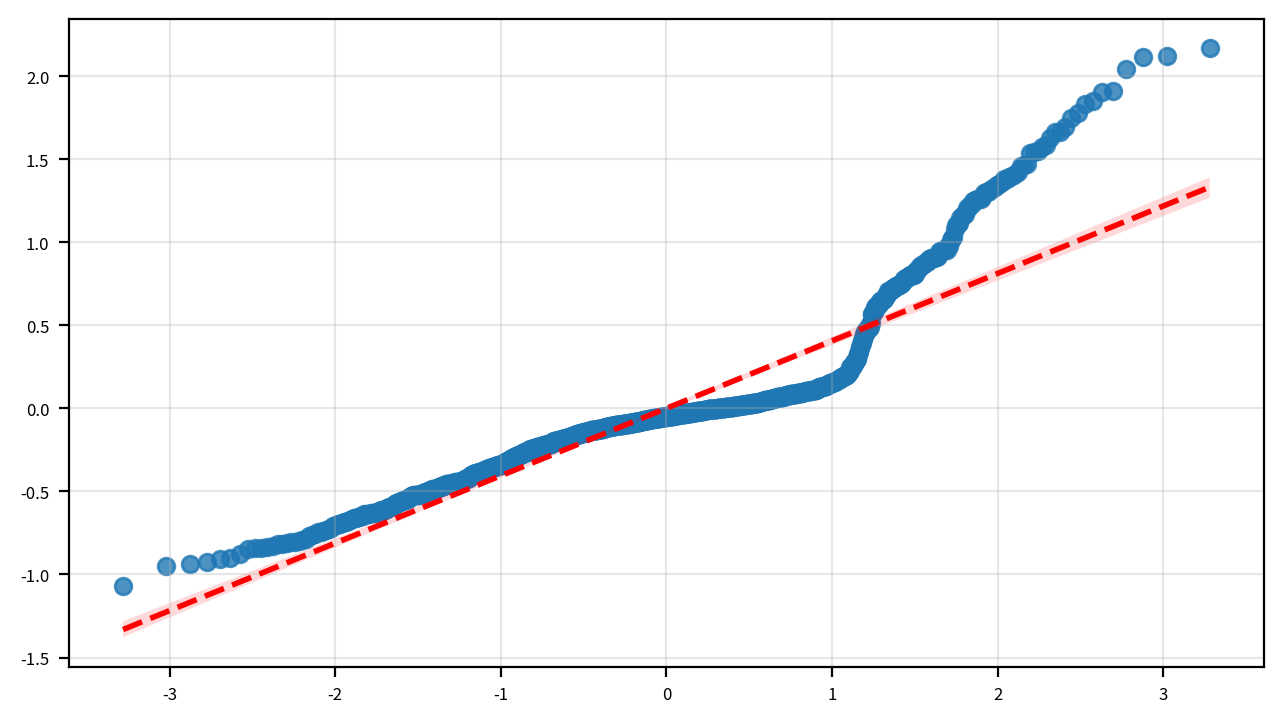

In [43]:
(x, y), _ = probplot(model.resid)

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
"color": "red",
"linestyle": "--",   
"linewidth": 2
            })
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)           

plt.tight_layout()      
plt.show()              
plt.close()             

In [44]:
stats.shapiro(model.resid)

ShapiroResult(statistic=np.float64(0.8373047526556342), pvalue=np.float64(6.800944817279797e-35))

2. 선형성 검정, 결과 : 위배 가능성 있음

In [45]:
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 287.1425
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


3.  잔차의 독립성 검정, 결과 : 독립성 만족

In [46]:
dw = durbin_watson(model.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 2.046
잔차는 독립성을 만족함 (자기상관 없음)


4. 등분산성 검정, 결과 : 등분산 아님

In [47]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 10.155, p-value = 0.000
이분산성 존재(등분산 아님)


+ 다중공선성 검토

In [48]:
df10 = dfl.drop(columns = 'age_group', axis=1)
df10 = pd.get_dummies(df10, dtype = 'int', drop_first=True)

In [49]:
vif_list2 = []
for i in range(df10.shape[1]):
    vif_values = variance_inflation_factor(df10.values, i)
    vif_list2.append(vif_values)
df7v = pd.DataFrame({
    'feature' : df10.columns,
    'VIF' : vif_list2
})
df7v

,feature,VIF
0,age,12.489479
1,bmi,29.643103
2,children,1.884745
3,charges,52.685856
4,sex_male,2.021401
5,smoker_yes,1.694909
6,region_northwest,1.976522
7,region_southeast,2.265588
8,region_southwest,1.992296


다중공선성 문제를 해결하기 위해 10이 넘는 bmi 제거(charges는 타겟 변수라 조정 대상이 아님 그래서 2번째로 높은 bmi부터 삭제)

In [50]:
df10 = df10.drop(columns='bmi', axis = 1)
vif_list2 = []
for i in range(df10.shape[1]):
    vif_values = variance_inflation_factor(df10.values, i)
    vif_list2.append(vif_values)
df7v = pd.DataFrame({
    'feature' : df10.columns,
    'VIF' : vif_list2
})
df7v

,feature,VIF
0,age,12.230658
1,children,1.878291
2,charges,20.187810
3,sex_male,2.009940
4,smoker_yes,1.491512
5,region_northwest,1.975330
6,region_southeast,2.082336
7,region_southwest,1.964330


다중공선성 문제를 해결하기 위해 10이 넘는 age 제거

In [51]:
df10 = df10.drop(columns='age', axis = 1)
vif_list2 = []
for i in range(df10.shape[1]):
    vif_values = variance_inflation_factor(df10.values, i)
    vif_list2.append(vif_values)
df7v = pd.DataFrame({
    'feature' : df10.columns,
    'VIF' : vif_list2
})
df7v

,feature,VIF
0,children,1.874230
1,charges,6.356166
2,sex_male,2.005049
3,smoker_yes,1.380443
4,region_northwest,1.968154
5,region_southeast,2.075043
6,region_southwest,1.959962


회귀분석 다시 실시

In [52]:
model10 = ols('charges ~ children + sex_male + smoker_yes + region_northwest + region_southeast + region_southwest', data = df10).fit()
print(model10.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     198.2
Date:                Wed, 07 Jan 2026   Prob (F-statistic):          1.45e-180
Time:                        14:29:49   Log-Likelihood:                -1358.6
No. Observations:                1338   AIC:                             2731.
Df Residuals:                    1331   BIC:                             2768.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.7721      0.045  

유의하지 않는 칼럼 제거 후 회귀분석 재실시

In [53]:
model10 = ols('charges ~ children + sex_male + smoker_yes + region_southeast + region_southwest', data = df10).fit()
print(model10.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     237.4
Date:                Wed, 07 Jan 2026   Prob (F-statistic):          2.09e-181
Time:                        14:30:30   Log-Likelihood:                -1359.5
No. Observations:                1338   AIC:                             2731.
Df Residuals:                    1332   BIC:                             2762.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.7379      0.037  

In [55]:
model10 = ols('charges ~ children + sex_male + smoker_yes + region_southeast ', data = df10).fit()
print(model10.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     295.8
Date:                Wed, 07 Jan 2026   Prob (F-statistic):          3.91e-182
Time:                        14:31:39   Log-Likelihood:                -1360.7
No. Observations:                1338   AIC:                             2731.
Df Residuals:                    1333   BIC:                             2757.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.7143      0.034  

In [56]:
model10 = ols('charges ~ children + sex_male + smoker_yes', data = df10).fit()
print(model10.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     393.7
Date:                Wed, 07 Jan 2026   Prob (F-statistic):          4.13e-183
Time:                        14:31:58   Log-Likelihood:                -1361.6
No. Observations:                1338   AIC:                             2731.
Df Residuals:                    1334   BIC:                             2752.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7005      0.032    274.190      0.0

In [57]:
model10.params[:]

Intercept     8.700478
children      0.119783
sex_male     -0.088157
smoker_yes    1.521454
dtype: float64

In [59]:
model10.rsquared

np.float64(0.46959239180115697)

최종모델 회귀식 : charges^ = 8.700478 + 0.119783children^ -0.088157C(sex)[T.male] + 1.521454C(smoker)[T.yes]
결정계수 : 0.47

## 미션 11. “회귀계수는 무엇을 말해주나?”

11-1 계수(또는 표준화 계수)와 신뢰구간, 방향·크기를 해석한다

In [60]:
model10.params[:]

Intercept     8.700478
children      0.119783
sex_male     -0.088157
smoker_yes    1.521454
dtype: float64

양의 방향 C(smoker)[T.yes], children
음의 방향 상수항, C(sex)[T.male]

11-2 "나이가 1년 늘면 의료비가 어떻게 변하는가”, “흡연자는 비흡연자보다 평균 얼마나 더 높은 비용을 지불하는가” 처럼 물리/의료적 의미로 번역한다.

회귀식 : charges^ = 8.700478 + 0.119783children^ -0.088157C(sex)[T.male] + 1.521454C(smoker)[T.yes]
children:
자녀 수가 1명 증가할 때, 다른 조건이 동일하다면 의료보험 청구 비용은 약 (exp(0.119783) - 1) * 100 = 12.72 증가한다.

smoker_yes:
흡연자는 비흡연자에 비해, 다른 변수들을 통제한 상태에서 의료보험 청구 비용은 약 (exp(1.521454) - 1) * 100% = 358.00 높게 나타난다.

sex_male:
남성은 여성에 비해, 다른 변수들을 통제한 상태에서 의료보험 청구 비용은 약 (exp(-0.088157) - 1) * 100% = -8.43 낮게 나타난다.

## 미션 12. “모형 진단과 개선”

미션10에서 진행완료!

In [61]:
y = df10['charges']
y_pred = model10.predict(df10)

In [62]:
from sklearn.metrics import root_mean_squared_error as rmse, mean_squared_error as mse, mean_absolute_error as mae
rmse1 = rmse(y, y_pred)
mse1 = mse(y, y_pred)
mae1 = mae(y, y_pred)
print(rmse1, ',', mse1, ',', mae1)

0.6694329096297547 , 0.44814042049535924 , 0.5515203523752313


RMSE와 MAE 기준으로 볼 때, 본 회귀모형의 예측 오차는 로그 스케일에서 평균적으로 약 0.5~0.7 수준으로 나타났으며, 극단적인 오차 없이 비교적 안정적인 예측 성능을 보인다.

## 미션 13. “같은 나이인데 왜 의료비는 다를까?”

In [63]:
df10.head(3)

,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0,9.734176,0,1,0,0,1
1,1,7.453302,1,0,0,1,0
2,3,8.400538,1,0,0,1,0


In [64]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [65]:
sample = pd.DataFrame({
    'age' : [33, 33],
    'sex_male' : [1, 0],
    'children' : [1,3], 
    'smoker_yes' : [0, 1], 
    'region_northwest' : [0, 0],
    'region_southeast' : [1, 0],
    'region_southwest' : [0, 1]
})
sample

,age,sex_male,children,smoker_yes,region_northwest,region_southeast,region_southwest
0,33,1,1,0,0,1,0
1,33,0,3,1,0,0,1


In [66]:
model10.predict(sample)

0     8.732104
1    10.581279
dtype: float64

두 사람은 동일한 나이(33세)를 가지고 있다. A는 비흡연자이며 남성, 자녀가 1명이다. B는 흡연자이며 여성, 자녀가 3명이다.
회귀분석 결과에 따르면, 흡연자는 비흡연자에 비해 의료비가 평균적으로 약 (exp(1.5229) - 1)만큼 증가하는 것으로 나타났으며, 자녀 수는 1명 증가할 때마다 의료비가 약 (exp(0.1203) - 1)만큼 증가하는 것으로 추정된다.
model10, 최종모형에는 age 변수가 포함되지 않았으므로, 동일한 나이 조건에서도 흡연 여부와 자녀 수, 거주 지역 등의 개인 특성에 따라 의료비 예측값에 차이가 발생한다. 이에 따라 흡연자이면서 자녀 수가 많은 B의 예상 의료비가 A보다 더 높게 나타난다.
다만 본 모형은 개인의 건강 이력, 유전적 요인, 사회경제적 지위, 의료 접근성 등의 요인을 반영하지 못한다는 한계가 있다.